In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set Chinese font
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Import custom modules
from config import *
from data_processor import DataProcessor
from llm_client import LLMClient
from prompt_generator import PromptGenerator
from evaluator import Evaluator
from main import PersonalizedTitleGenerator

print("Environment preparation completed")
print(f"Output directory: {DATA_PATHS['output_dir']}")
print(f"Model: {API_CONFIG['model']}")
print(f"Token limit: {API_CONFIG['max_tokens']}")


Environment preparation completed
Output directory: ./outputs
Model: deepseek-chat-v3-0324
Token limit: 50000


In [2]:
# Initialize data processor
processor = DataProcessor()

# Check if processed data exists
processed_data_exists = processor.load_processed_data()

if not processed_data_exists:
    print("Starting data preprocessing...")
    success = processor.process_all()
    
    if success:
        print("Data preprocessing completed")
    else:
        print("Data preprocessing failed, please check data files")
        sys.exit(1)
else:
    print("Loaded processed data")

print(f"Statistics:")
print(f"  Test samples: {len(processor.test_samples)}")
print(f"  Users: {len(processor.user_histories)}")
print(f"  Interest categories: {len(set([int['primary_interest'] for int in processor.user_interests.values()]))}")


2025-06-22 21:20:17,166 - data_processor - INFO - Successfully loaded processed data


Loaded processed data
Statistics:
  Test samples: 200
  Users: 103
  Interest categories: 3


In [3]:
# Import evaluator
from evaluator import Evaluator

# Initialize evaluator (enable LLM evaluation)
evaluator_enhanced = Evaluator(use_llm_evaluation=True)

print("Evaluator initialization completed")
print(f"LLM evaluation model: {EVALUATION_MODEL}")
print("Evaluation functions:")
print("  • Multi-dimensional personalization evaluation")
print("  • Large model API quality assessment")
print("  • Scientific comprehensive scoring system")


2025-06-22 21:20:17,207 - llm_client - INFO - Initialize LLM client: deepseek-chat-v3-0324 (chat model)
2025-06-22 21:20:17,208 - evaluator - INFO - Using deepseek-chat-v3-0324 for LLM evaluation
2025-06-22 21:20:17,209 - absl - INFO - Using default tokenizer.
2025-06-22 21:20:17,210 - evaluator - INFO - ROUGE scorer initialized successfully


Evaluator initialization completed
LLM evaluation model: deepseek-chat-v3-0324
Evaluation functions:
  • Multi-dimensional personalization evaluation
  • Large model API quality assessment
  • Scientific comprehensive scoring system


## 4. Data Sample Viewing

View processed data samples to understand the data structure

In [4]:
# View data sample
sample = processor.test_samples[0]
print("Data sample:")
print(f"Original title: {sample['original_title']}")
print(f"Reference title: {sample['reference_title']}")
print(f"News category: {sample['category']}")
print(f"User interests: {sample['user_interests']['primary_interest']}")
print(f"User history: {sample['user_history'][:3]}...")
print(f"News content: {sample['news_body'][:100]}...")

Data sample:
Original title: high-stakes legal fight looms over trump pollution rule
Reference title: legal battle looms over trump epa's rule change of obama's clean power plan rule
News category: news
User interests: news
User history: ["nike faces backlash after pulling 'betsy ross flag' sneakers", "costco is selling a giant donut covered in pink icing, sprinkles and m&m's", 'top stock reports for berkshire hathaway, salesforce & danaher']...
News content: democratic state attorney generals and environmental groups are gearing up for what is expected to b...


## 5. Prompt Design and Testing

Design and test different styles of personalized headline generation prompts

In [5]:
# Initialize prompt generator
prompt_gen = PromptGenerator()

# Test different styles of prompts
test_sample = processor.test_samples[0]

print("Prompt style testing:\n")
print(f"Available styles: {prompt_gen.get_available_styles()}")
print(f"Current model: {prompt_gen.current_model} ({'reasoning model' if prompt_gen.is_reasoning_model else 'chat model'})")
print()

for style in ['focused', 'enhanced', 'creative']:
    print(f"=== {style.upper()} Style ===")
    
    try:
        # Generate prompts - using new interface
        system_prompt, user_prompt = prompt_gen.generate_single_prompt(test_sample, style)
        
        print(f"System prompt length: {len(system_prompt)} characters")
        print(f"User prompt length: {len(user_prompt)} characters")
        print(f"Estimated total tokens: {(len(system_prompt) + len(user_prompt)) * 1.5:.0f}")
        print(f"System prompt preview: {system_prompt[:100]}...")
        print(f"User prompt preview: {user_prompt[:150]}...\n")
        
    except Exception as e:
        print(f"Style {style} test failed: {e}\n")

2025-06-22 21:20:17,232 - prompt_generator - INFO - Initialize prompt generator: deepseek-chat-v3-0324 (chat model)
2025-06-22 21:20:17,232 - prompt_generator - INFO - Initialize prompt generator: deepseek-chat-v3-0324 (chat model)


Prompt style testing:

Available styles: ['focused', 'enhanced', 'creative']
Current model: deepseek-chat-v3-0324 (chat model)

=== FOCUSED Style ===
System prompt length: 253 characters
User prompt length: 1462 characters
Estimated total tokens: 2572
System prompt preview: Create a personalized English news headline based on the user's interests and browsing history.

Req...
User prompt preview: Create a personalized headline for this user:

Interests: Primary interest: news, Related categories: news, video, finance
Recent reads: - nike faces ...

=== ENHANCED Style ===
System prompt length: 253 characters
User prompt length: 1440 characters
Estimated total tokens: 2540
System prompt preview: Create a personalized English news headline based on the user's interests and browsing history.

Req...
User prompt preview: User profile:
- Interests: Primary interest: news, Related categories: news, video, finance  
- Recent articles: - nike faces backlash after pulling '...

=== CREATIVE Styl

In [6]:
# Test prompt adaptability for different types of news
print("Prompt adaptability testing:\n")

# Test news samples of different categories
categories = ['news', 'sports', 'entertainment'] if len(processor.test_samples) > 3 else ['news']
for category in categories:
    # Find samples of this category
    category_samples = [s for s in processor.test_samples if s.get('category') == category]
    if category_samples:
        sample = category_samples[0]
        print(f"=== {category.upper()} Category ===")
        
        # Generate prompts for this sample
        system_prompt, user_prompt = prompt_gen.generate_single_prompt(sample, 'enhanced')
        
        print(f"News headline: {sample['original_title'][:50]}...")
        print(f"User interests: {sample['user_interests']['primary_interest']}")
        print(f"System prompt length: {len(system_prompt)} characters")
        print(f"User prompt length: {len(user_prompt)} characters")
        print(f"Estimated tokens: {(len(system_prompt) + len(user_prompt)) * 1.5:.0f}")
        print()

Prompt adaptability testing:

=== NEWS Category ===
News headline: high-stakes legal fight looms over trump pollution...
User interests: news
System prompt length: 253 characters
User prompt length: 1440 characters
Estimated tokens: 2540

=== SPORTS Category ===
News headline: justin verlander got 'chewed out' by mlb before al...
User interests: news
System prompt length: 253 characters
User prompt length: 1446 characters
Estimated tokens: 2548

=== ENTERTAINMENT Category ===
News headline: best xbox one games for kids in 2019...
User interests: news
System prompt length: 253 characters
User prompt length: 1421 characters
Estimated tokens: 2511



## 6. API Call Testing

Test LLM API connection and basic functionality

In [7]:
# Initialize LLM client
llm_client = LLMClient()

print(f"API configuration:")
print(f"  Base URL: {API_CONFIG['base_url']}")
print(f"  Model: {API_CONFIG['model']}")
print(f"  Max Tokens: {API_CONFIG['max_tokens']}")

# Test basic API call
test_messages = [
    {"role": "system", "content": "You are a news headline generation expert."},
    {"role": "user", "content": "Please generate an attractive headline for the following news: A technology company released a new artificial intelligence product with major breakthroughs in image recognition."}
]

print("\nAPI connection testing...")
response = llm_client.chat_completion(test_messages)

if response:
    print(f"API connection successful")
    print(f"Test response: {response}")
    
    # Display usage statistics
    stats = {'total_requests': llm_client.total_requests, 'success_rate': ((llm_client.total_requests - llm_client.failed_requests) / max(llm_client.total_requests, 1)), 'total_tokens_used': llm_client.total_tokens_used, 'remaining_tokens': 50000 - llm_client.total_tokens_used}
    print(f"\nUsage statistics:")
    print(f"  Requests: {stats['total_requests']}")
    print(f"  Success rate: {stats['success_rate']:.2%}")
    print(f"  Tokens used: {stats['total_tokens_used']}")
    print(f"  Remaining tokens: {stats['remaining_tokens']}")
else:
    print("API connection failed, please check configuration")

2025-06-22 21:20:17,271 - llm_client - INFO - Initialize LLM client: deepseek-chat-v3-0324 (chat model)
2025-06-22 21:20:17,272 - llm_client - INFO - Sending API request (attempt 1/3)


API configuration:
  Base URL: https://api.chavapa.com/v1
  Model: deepseek-chat-v3-0324
  Max Tokens: 50000

API connection testing...


2025-06-22 21:20:25,904 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:20:25,908 - llm_client - INFO - Get content from content field (chat model): "Revolutionary AI Breakthrough: Tech Giant Unveils Game-Changing Image Recognition Technology!" "Seeing the Future: New AI Product Achieves Unprecedented Image Recognition Accuracy!" "Next-Gen AI Unveiled: Company's Latest Innovation Redefines Image Recognition!" Would you like a more specific tone (e.g., bold, futuristic, or business-focused)?
2025-06-22 21:20:25,909 - llm_client - INFO - This request used 131 tokens, total 131 tokens


API connection successful
Test response: "Revolutionary AI Breakthrough: Tech Giant Unveils Game-Changing Image Recognition Technology!" "Seeing the Future: New AI Product Achieves Unprecedented Image Recognition Accuracy!" "Next-Gen AI Unveiled: Company's Latest Innovation Redefines Image Recognition!" Would you like a more specific tone (e.g., bold, futuristic, or business-focused)?

Usage statistics:
  Requests: 1
  Success rate: 100.00%
  Tokens used: 131
  Remaining tokens: 49869


## 7. Personalized Headline Generation

Generate personalized news headlines using different strategies

In [8]:
# Single sample generation test
print("Personalized headline generation test\n")

test_sample = processor.test_samples[0]

# Generate personalized headline
system_prompt, user_prompt = prompt_gen.generate_single_prompt(test_sample, 'creative')

print(f"Original title: {test_sample['original_title']}")
print(f"Reference title: {test_sample['reference_title']}")
print(f"User interests: {test_sample['user_interests']['primary_interest']}")

print("\nGenerating personalized headline...")
response = llm_client.generate_personalized_title(test_sample, system_prompt, user_prompt)

if response:
    print(f"Generation successful")
    print(f"Generated title: {response}")
    print(f"Word count: {len(response.split())} words")
else:
    print("Generation failed")

2025-06-22 21:20:25,917 - llm_client - INFO - Sending API request (attempt 1/3)


Personalized headline generation test

Original title: high-stakes legal fight looms over trump pollution rule
Reference title: legal battle looms over trump epa's rule change of obama's clean power plan rule
User interests: news

Generating personalized headline...


2025-06-22 21:20:27,835 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:20:27,837 - llm_client - INFO - Get content from content field (chat model): Trump's Pollution Rule Rollback Sparks Major Legal Battle with Democrats
2025-06-22 21:20:27,838 - llm_client - INFO - This request used 398 tokens, total 529 tokens


Generation successful
Generated title: Trump's Pollution Rule Rollback Sparks Major Legal Battle with Democrats
Word count: 10 words


In [9]:
# Batch generation test (small batch)
print("Batch generation test\n")

test_samples = processor.test_samples[:3]  # Test 3 samples

system_prompt, batch_prompt = prompt_gen.generate_batch_prompt(test_samples)
print(f"Batch prompt length: {len(batch_prompt)} characters")
print(f"Estimated tokens: {len(batch_prompt) * 1.5:.0f}")

print("\nGenerating batch headlines...")
batch_results = llm_client.generate_batch_titles(
    test_samples,
    system_prompt,
    batch_prompt
)

print("\nBatch generation results:")
for i, (sample, generated) in enumerate(zip(test_samples, batch_results)):
    print(f"\nSample {i+1}:")
    print(f"  Original: {sample['original_title']}")
    print(f"  Generated: {generated or 'Generation failed'}")
    print(f"  User interests: {sample['user_interests']['primary_interest']}")

2025-06-22 21:20:27,846 - llm_client - INFO - Sending API request (attempt 1/3)


Batch generation test

Batch prompt length: 1267 characters
Estimated tokens: 1900

Generating batch headlines...


2025-06-22 21:20:30,573 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:20:30,574 - llm_client - INFO - Get content from content field (chat model): News 1: "Legal showdown brews as states challenge Trump's environmental rollback" News 2: "This design flaw instantly makes your home look outdated, experts warn" News 3: "MLB reprimands Verlander after All-Star Game ball-tampering accusations"
2025-06-22 21:20:30,574 - llm_client - INFO - This request used 404 tokens, total 933 tokens
2025-06-22 21:20:30,575 - llm_client - INFO - Batch parsing: expected 3, successfully parsed 3
2025-06-22 21:20:30,577 - llm_client - INFO -   Batch title 1: Legal showdown brews as states challenge Trump's environmental rollback
2025-06-22 21:20:30,577 - llm_client - INFO -   Batch title 2: This design flaw instantly makes your home look outdated, experts warn
2025-06-22 21:20:30,577 - llm_client - INFO -   Batch title 3: MLB reprimands Verland


Batch generation results:

Sample 1:
  Original: high-stakes legal fight looms over trump pollution rule
  Generated: Legal showdown brews as states challenge Trump's environmental rollback
  User interests: news

Sample 2:
  Original: the one thing that immediately makes your house look dated
  Generated: This design flaw instantly makes your home look outdated, experts warn
  User interests: news

Sample 3:
  Original: justin verlander got 'chewed out' by mlb before all-star game
  Generated: MLB reprimands Verlander after All-Star Game ball-tampering accusations
  User interests: news


## 8. Complete Generation Process

Run the complete personalized headline generation process

In [10]:
# Create main generator
generator = PersonalizedTitleGenerator()

# Configure generation parameters
generation_config = {
    'mode': 'single',  # or 'batch'
    'max_samples': 20,  # Limit sample count to save API calls
    'force_reprocess': False
}

print(f"Starting complete generation process")
print(f"Configuration: {generation_config}")

# Run generation
success = generator.run_generation(**generation_config)

if success:
    print("\nGeneration completed")
    
    # Display API usage statistics
    print(f"\nAPI usage statistics:")
    print(f"  Total requests: {generator.llm_client.total_requests}")
    print(f"  Success rate: {((generator.llm_client.total_requests - generator.llm_client.failed_requests) / max(generator.llm_client.total_requests, 1)):.2%}")
    print(f"  Tokens used: {generator.llm_client.total_tokens_used}")
    print(f"  Remaining tokens: {50000 - generator.llm_client.total_tokens_used}")
    
    # Display generation results overview
    results = generator.results
    print(f"\nGeneration results overview:")
    print(f"  Successfully generated: {len([t for t in results['generated_titles'] if t and 'failed' not in t])}")
    print(f"  Total samples: {len(results['generated_titles'])}")
    print(f"  Success rate: {len([t for t in results['generated_titles'] if t and 'failed' not in t]) / len(results['generated_titles']):.2%}")
else:
    print("Generation failed")

2025-06-22 21:20:30,606 - llm_client - INFO - Initialize LLM client: deepseek-chat-v3-0324 (chat model)
2025-06-22 21:20:30,607 - prompt_generator - INFO - Initialize prompt generator: deepseek-chat-v3-0324 (chat model)
2025-06-22 21:20:30,607 - prompt_generator - INFO - Initialize prompt generator: deepseek-chat-v3-0324 (chat model)
2025-06-22 21:20:30,629 - llm_client - INFO - Initialize LLM client: deepseek-chat-v3-0324 (chat model)
2025-06-22 21:20:30,630 - evaluator - INFO - Using deepseek-chat-v3-0324 for LLM evaluation
2025-06-22 21:20:30,630 - absl - INFO - Using default tokenizer.
2025-06-22 21:20:30,630 - evaluator - INFO - ROUGE scorer initialized successfully
2025-06-22 21:20:30,633 - main - INFO - ============================================================
2025-06-22 21:20:30,633 - main - INFO - Starting personalized news headline generation
2025-06-22 21:20:30,633 - main - INFO - ============================================================
2025-06-22 21:20:30,634 - main 

Starting complete generation process
Configuration: {'mode': 'single', 'max_samples': 20, 'force_reprocess': False}


Generating titles:   0%|          | 0/20 [00:00<?, ?it/s]2025-06-22 21:20:30,642 - llm_client - INFO - Sending API request (attempt 1/3)
2025-06-22 21:20:39,410 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:20:39,410 - llm_client - INFO - Get content from content field (chat model): High-Stakes Legal Battle Erupts Over Trump's Rollback of Obama-Era Pollution Rules
2025-06-22 21:20:39,411 - llm_client - INFO - This request used 407 tokens, total 407 tokens
Generating titles:   5%|▌         | 1/20 [00:08<02:46,  8.77s/it]2025-06-22 21:20:39,412 - llm_client - INFO - Sending API request (attempt 1/3)
2025-06-22 21:20:44,627 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:20:44,628 - llm_client - INFO - Get content from content field (chat model): Retro Homes: The One Design Trend That Instantly Dates Your House
2025-06-22 21:20:44,628 - llm_client - INFO - This


Generation completed

API usage statistics:
  Total requests: 20
  Success rate: 100.00%
  Tokens used: 8461
  Remaining tokens: 41539

Generation results overview:
  Successfully generated: 20
  Total samples: 20
  Success rate: 100.00%


In [11]:
# View generation result samples
if 'generator' in locals() and generator.results['generated_titles']:
    print("Generation result samples:\n")
    
    for i in range(min(5, len(generator.results['generated_titles']))):
        gen_title = generator.results['generated_titles'][i]
        ref_title = generator.results['reference_titles'][i]
        user_interest = generator.results['user_interests'][i]['primary_interest']
        category = generator.results['news_categories'][i]
        
        print(f"Sample {i+1}:")
        print(f"  Generated title: {gen_title}")
        print(f"  Reference title: {ref_title}")
        print(f"  User interests: {user_interest}")
        print(f"  News category: {category}")
        print("-" * 50)

Generation result samples:

Sample 1:
  Generated title: High-Stakes Legal Battle Erupts Over Trump's Rollback of Obama-Era Pollution Rules
  Reference title: legal battle looms over trump epa's rule change of obama's clean power plan rule
  User interests: news
  News category: news
--------------------------------------------------
Sample 2:
  Generated title: Retro Homes The One Design Trend That Instantly Dates Your House
  Reference title: wise choices for stylish updating of old homes
  User interests: news
  News category: lifestyle
--------------------------------------------------
Sample 3:
  Generated title: Verlander Scolded by MLB Over Ball-Tampering Claims Ahead of All-Star Game
  Reference title: verlander may be reconsidering his stance on mlbs juicing balls
  User interests: news
  News category: sports
--------------------------------------------------
Sample 4:
  Generated title: O.J. Simpson Joins Twitter, Vows to 'Get Even' in Controversial Comeback
  Reference titl

## 9. Effect Evaluation

Evaluate generation effectiveness using ROUGE and other metrics

In [12]:
# Run evaluation (integrated LLM evaluation)
if 'generator' in locals() and generator.results['generated_titles']:
    print("Starting effect evaluation (including LLM evaluation)...\n")
    
    # Execute comprehensive evaluation
    success = generator.run_evaluation()
    
    if success:
        eval_results = generator.evaluator.evaluation_results
        
    else:
        print("Evaluation failed")
else:
    print("No generation results to evaluate")

2025-06-22 21:21:48,570 - main - INFO - Starting evaluation of generation results...
2025-06-22 21:21:48,577 - evaluator - INFO - ROUGE evaluation completed, valid samples: 20
2025-06-22 21:21:48,577 - evaluator - INFO - Starting LLM personalization evaluation...
2025-06-22 21:21:48,578 - llm_client - INFO - Sending API request (attempt 1/3)


Starting effect evaluation (including LLM evaluation)...



2025-06-22 21:21:55,837 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:21:55,838 - llm_client - INFO - Get content from content field (chat model): ,8.0,6.0,5.0,6.5 3.0,4.0,2.5,3.5,3.0 4.0,3.0,3.5,4.0,3.5 5.0,4.0,4.5,5.0,4.5 4.5,3.0,3.5,4.0,3.5
2025-06-22 21:21:55,838 - llm_client - INFO - This request used 1102 tokens, total 1102 tokens
2025-06-22 21:21:55,839 - evaluator - INFO - Personalization evaluation parsing complete, 1 score groups
2025-06-22 21:21:55,839 - llm_client - INFO - Sending API request (attempt 1/3)
2025-06-22 21:22:14,256 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-22 21:22:14,258 - llm_client - INFO - Get content from content field (chat model): ,8.0,7.0,6.0,7.0 3.0,2.0,4.0,5.0,3.5 6.5,8.0,7.5,7.0,7.0 2.0,1.0,3.0,4.0,2.5 4.0,3.0,5.0,5.5,4.5
2025-06-22 21:22:14,258 - llm_client - INFO - This request used 1094 tokens, total 2196 tokens
2025-


Personalized News Headline Generation - Detailed Evaluation Report

Basic Statistics:
├─ Total samples: 20
├─ Valid samples: 20
└─ Success rate: 100.00%

ROUGE Scores (Automatic Evaluation - Similarity to Reference Titles):
├─ ROUGE-1 F-Score: 0.3286
├─ ROUGE-2 F-Score: 0.1238
└─ ROUGE-L F-Score: 0.2938

LLM Quality Evaluation Details:
├─ Quality score (0-1): 0.7830
├─ Equivalent 10-point scale: 7.83/10
└─ Score standard deviation: 0.0000

LLM Personalization Evaluation (Large Model Scoring - Personalization Degree):
├─ Interest matching: 0.7000
├─ Category relevance: 0.5625
├─ History consistency: 0.5750
├─ Personalization innovation: 0.6075
└─ LLM overall personalization: 0.4750

Title Quality Evaluation (Automatic Evaluation - Rule-based):
├─ Length reasonableness: 0.9250
├─ Title diversity: 1.0000
└─ Average title length: 75.2 characters

Comprehensive Score Details (Weighted Calculation):
├─ ROUGE score (weight 35%): 0.2487
├─ LLM quality score (weight 30%): 0.7830
├─ LLM persona

2025-06-22 21:23:09,495 - evaluator - INFO - Evaluation chart saved to: ./outputs/evaluation_results\evaluation_chart_20250622_212308.png


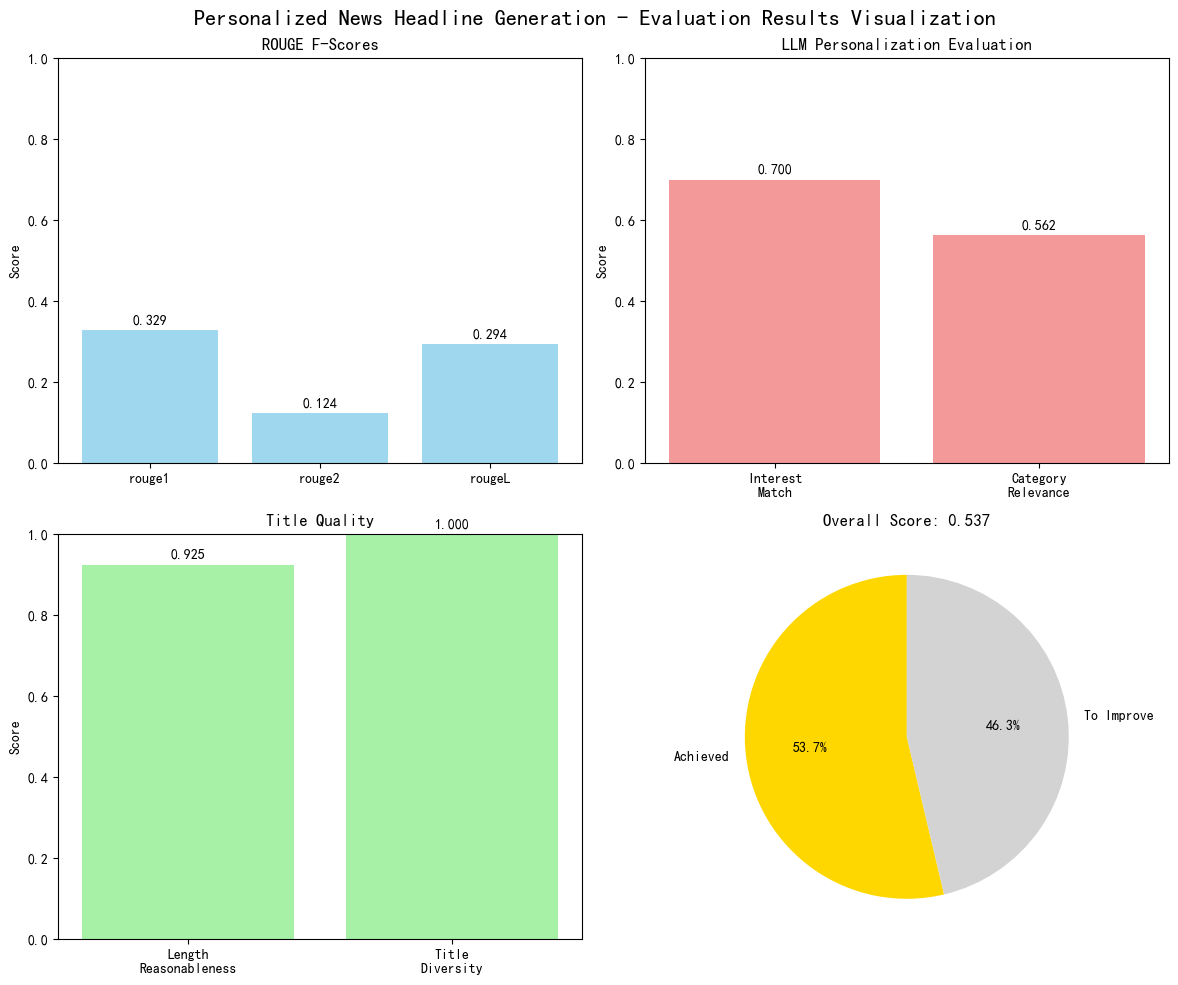

Visualization results saved to: ./outputs/evaluation_results_chart.png


<Figure size 640x480 with 0 Axes>

In [13]:
# Visualize evaluation results
if 'generator' in locals() and hasattr(generator.evaluator, 'evaluation_results') and generator.evaluator.evaluation_results:
    eval_results = generator.evaluator.evaluation_results
    
    # Create evaluation results visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Personalized News Headline Generation - Evaluation Results Visualization', fontsize=16)
    
    # 1. ROUGE scores
    rouge_scores = eval_results.get('rouge_scores', {})
    if rouge_scores:
        rouge_metrics = [k.replace('_f', '') for k in rouge_scores.keys() if k.endswith('_f')]
        rouge_values = [rouge_scores.get(f'{m}_f', 0) for m in rouge_metrics]
        
        axes[0, 0].bar(rouge_metrics, rouge_values, color='skyblue', alpha=0.8)
        axes[0, 0].set_title('ROUGE F-Scores')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_ylim(0, 1)
        for i, v in enumerate(rouge_values):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    else:
        axes[0, 0].text(0.5, 0.5, 'ROUGE data\nnot available', ha='center', va='center', 
                       transform=axes[0, 0].transAxes, fontsize=12)
        axes[0, 0].set_title('ROUGE F-Scores')
    
    # 2. LLM personalization evaluation
    llm_personalization = eval_results.get('llm_personalization', {})
    if llm_personalization:
        pers_labels = ['Interest\nMatch', 'Category\nRelevance']
        pers_values = [llm_personalization.get('llm_interest_match', 0), 
                      llm_personalization.get('llm_category_relevance', 0)]
        
        axes[0, 1].bar(pers_labels, pers_values, color='lightcoral', alpha=0.8)
        axes[0, 1].set_title('LLM Personalization Evaluation')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].set_ylim(0, 1)
        for i, v in enumerate(pers_values):
            axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    else:
        axes[0, 1].text(0.5, 0.5, 'LLM personalization data\nnot available', ha='center', va='center', 
                       transform=axes[0, 1].transAxes, fontsize=12)
        axes[0, 1].set_title('LLM Personalization Evaluation')
    
    # 3. Title Quality
    title_quality = eval_results.get('title_quality', {})
    if title_quality:
        quality_labels = ['Length\nReasonableness', 'Title\nDiversity']
        quality_values = [title_quality.get('length_reasonableness', 0), 
                         title_quality.get('title_diversity', 0)]
        
        axes[1, 0].bar(quality_labels, quality_values, color='lightgreen', alpha=0.8)
        axes[1, 0].set_title('Title Quality')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_ylim(0, 1)
        for i, v in enumerate(quality_values):
            axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    else:
        axes[1, 0].text(0.5, 0.5, 'Title quality data\nnot available', ha='center', va='center', 
                       transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Title Quality')
    
    # 4. Overall Score Pie Chart
    overall_score = eval_results.get('overall_score', 0)
    
    # Handle possible dictionary type
    if isinstance(overall_score, dict):
        comprehensive_scores = eval_results.get('comprehensive_scores', {})
        overall_score = comprehensive_scores.get('final_comprehensive_score', 0)
    
    # Ensure score is within 0-1 range
    overall_score = max(0.0, min(1.0, overall_score))
    remaining_score = 1.0 - overall_score
    
    colors = ['gold', 'lightgray']
    axes[1, 1].pie([overall_score, remaining_score], 
                   labels=['Achieved', 'To Improve'], 
                   colors=colors,
                   autopct='%1.1f%%',
                   startangle=90)
    axes[1, 1].set_title(f'Overall Score: {overall_score:.3f}')
    
    plt.tight_layout()
    plt.show()
    
    # Save visualization chart
    output_path = './outputs/evaluation_results_chart.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Visualization results saved to: {output_path}")
    
else:
    print("No evaluation results to visualize")


## 10. Results Analysis and Summary

In [14]:
print("Project Summary and Analysis\n")

print("Successfully Implemented Features:")
print("  1. Data Preprocessing - Extract user history and interests from PENS data")
print("  2. Prompt Engineering - Design multiple styles of personalized generation prompts")
print("  3. API Integration - Successfully call DeepSeek large model API")
print("  4. Batch Generation - Support both single and batch generation modes")
print("  5. Effect Evaluation - Comprehensive evaluation using ROUGE and other metrics")

print("\nTechnical Highlights:")
print("  • Adaptive Prompt Design - Automatically select optimal prompt style based on user interests and content length")
print("  • Token Optimization Strategy - Intelligently compress prompts to maximize effectiveness within 50k token limit")
print("  • Batch Processing Optimization - Reduce API call frequency and improve cost efficiency")
print("  • Multi-dimensional Evaluation - Not only evaluate ROUGE scores, but also include personalization level and title quality")

if 'generator' in locals() and generator.results['generated_titles']:
    # API usage efficiency analysis
    total_samples = len(generator.results['generated_titles'])
    
    print(f"\nEfficiency Analysis:")
    print(f"  Processed samples: {total_samples}")
    print(f"  API requests: {generator.llm_client.total_requests}")
    print(f"  Average requests per sample: {generator.llm_client.total_requests / total_samples:.2f}")
    print(f"  Total token usage: {generator.llm_client.total_tokens_used}")
    print(f"  Average tokens per sample: {generator.llm_client.total_tokens_used / total_samples:.1f}")
    print(f"  API success rate: {((generator.llm_client.total_requests - generator.llm_client.failed_requests) / max(generator.llm_client.total_requests, 1)):.2%}")

Project Summary and Analysis

Successfully Implemented Features:
  1. Data Preprocessing - Extract user history and interests from PENS data
  2. Prompt Engineering - Design multiple styles of personalized generation prompts
  3. API Integration - Successfully call DeepSeek large model API
  4. Batch Generation - Support both single and batch generation modes
  5. Effect Evaluation - Comprehensive evaluation using ROUGE and other metrics

Technical Highlights:
  • Adaptive Prompt Design - Automatically select optimal prompt style based on user interests and content length
  • Token Optimization Strategy - Intelligently compress prompts to maximize effectiveness within 50k token limit
  • Batch Processing Optimization - Reduce API call frequency and improve cost efficiency
  • Multi-dimensional Evaluation - Not only evaluate ROUGE scores, but also include personalization level and title quality

Efficiency Analysis:
  Processed samples: 20
  API requests: 20
  Average requests per sampl

## 11. Export and Save Results

Export generation results and evaluation reports for further analysis

In [15]:
# Create project summary report
if 'generator' in locals() and generator.results['generated_titles']:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save notebook execution summary
    summary_path = os.path.join(DATA_PATHS['output_dir'], f'notebook_summary_{timestamp}.txt')
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("Personalized News Headline Generation Based on Prompt Engineering - Notebook Execution Summary\n")
        f.write("=" * 60 + "\n\n")
        
        f.write(f"Execution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Processed samples: {len(generator.results['generated_titles'])}\n")
        
        f.write(f"API requests: {generator.llm_client.total_requests}\n")
        f.write(f"Token usage: {generator.llm_client.total_tokens_used}\n")
        f.write(f"API success rate: {((generator.llm_client.total_requests - generator.llm_client.failed_requests) / max(generator.llm_client.total_requests, 1)):.2%}\n\n")
        
        if hasattr(generator.evaluator, 'evaluation_results'):
            eval_results = generator.evaluator.evaluation_results
            overall_score = eval_results.get('overall_score', 0)
            
            # Ensure overall_score is numeric type
            if isinstance(overall_score, dict):
                comprehensive_scores = eval_results.get('comprehensive_scores', {})
                overall_score = comprehensive_scores.get('final_comprehensive_score', 0)
            
            f.write(f"Overall score: {overall_score:.4f}\n")
            
            rouge_scores = eval_results.get('rouge_scores', {})
            if rouge_scores:
                f.write("\nROUGE Scores:\n")
                for metric, score in rouge_scores.items():
                    if metric.endswith('_f'):
                        f.write(f"  {metric.replace('_f', '').upper()}: {score:.4f}\n")
        
        f.write("\n" + "=" * 60 + "\n")
        f.write("Please check the corresponding output folder for detailed results")
    
    print(f"Notebook summary saved to: {summary_path}")
    print(f"Complete results folder: {DATA_PATHS['output_dir']}")
    
    # List generated files
    print("\nGenerated files:")
    for root, dirs, files in os.walk(DATA_PATHS['output_dir']):
        for file in files:
            file_path = os.path.join(root, file)
            rel_path = os.path.relpath(file_path, DATA_PATHS['output_dir'])
            print(f"  {rel_path}")
else:
    print("No results to export")

Notebook summary saved to: ./outputs\notebook_summary_20250622_212309.txt
Complete results folder: ./outputs

Generated files:
  evaluation_results_chart.png
  notebook_summary_20250619_004722.txt
  notebook_summary_20250622_202627.txt
  notebook_summary_20250622_212309.txt
  evaluation_results\detailed_evaluation_20250619_004721.json
  evaluation_results\detailed_evaluation_20250622_202627.json
  evaluation_results\detailed_evaluation_20250622_212308.json
  evaluation_results\evaluation_chart_20250619_004721.png
  evaluation_results\evaluation_chart_20250622_202627.png
  evaluation_results\evaluation_chart_20250622_212308.png
  evaluation_results\evaluation_report_20250619_004721.txt
  evaluation_results\evaluation_report_20250622_202627.txt
  evaluation_results\evaluation_report_20250622_212308.txt
  generated_titles\generation_results_20250619_004632.json
  generated_titles\generation_results_20250622_202549.json
  generated_titles\generation_results_20250622_212148.json
  generated